# Problem Set 2
## Fundamentals of Simulation Methods

#### Author:    Elias Olofsson

#### Version information:
        2020-11-15: v.1.0. First public release. 



## Exercise 1 - Pitfalls of pseudo-random number generators

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import time

m = 2**31
def randu(x):
    return (65539*x) % m

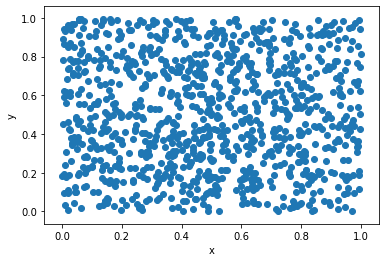

In [2]:
# Data points
n = 10**3

# Settings
filter_data = False     # Zoom ON/OFF. Not compatible with 3D plotting.
use_randu = True        # If True, RANDU is used. Else default python rng is used.
plot_3d = False         # Plot data in 3D using 3-tuples, otherwise 2D.

# Set dimensions accourding to plot settings above
if plot_3d:
    d = 3
else:
    d = 2

# If zoomed, specify limits of the square
x_low  = 0.2
x_high = 0.201
y_low  = 0.3
y_high = 0.301

# Allocate matrix with negative values
a = np.zeros(n*d, dtype = float)

# Seed the generator
if use_randu:
    seed = 113
    I = randu(seed)
else:
    np.random.seed(0)

# Generate random numbers
for i in range(n*d):
    if use_randu:
        I = randu(I)
        u = I/m
    else:
        u = np.random.random()

    # If zoom is enabled, filter values. If disabled, save all values.
    if filter_data:
        # Alternate for x and y. Save value if within limits.
        if (i % 2) == 0:
            if (u>x_low) and (u<x_high):
                a[i] = u
        else:
            if (u>y_low) and (u<y_high):
                a[i] = u
    else: 
        a[i] = u

# Reshape vector into n-by-d matrix
a = a.reshape(n,d)

# If filtering is on, remove all zeros from matrix 
if filter_data:
    a = a[(a[:,0]>0),:]
    a = a[(a[:,1]>0),:]

# Plotting 2D or 3D
if plot_3d:
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(a[:,0], a[:,1], a[:,2])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
else:
    plt.scatter(a[:,0], a[:,1])
    if filter_data:
        plt.xlim(x_low,x_high)
        plt.ylim(y_low,y_high)
    plt.xlabel("x")
    plt.ylabel("y")

plt.savefig("scatter.eps", format='eps',  bbox_inches='tight')

## Exercise 2 - Performance of Monte Carlo integration in different dimensions

In [3]:
def f(x):
    return 3/2*(1-x**2)

def midpoint(N,d):
    # Calc number of intervals per dimension
    n = round(N**(1/d))

    # Length of interval in 1D
    delta_x = 1/n

    # Vector of points in 1D
    x = np.linspace(0,1,n,endpoint=False)
    x = x + delta_x/2   # For midpoint rule, shift x pos to middle of interval.

    # Create matrix with d rows of vector x
    x_mat = np.zeros((d,n))
    x_mat = x_mat + x

    # Create list of length=d with d-dimensional meshgrids x^d = [0,1]^d
    X_tensor = np.meshgrid(*x_mat, sparse=True)

    # Calculate integral.  
    I = np.ones([n]*d)  # Initialize d-dimensional array with n elements in each dimension.
    for i in range(d):
        I *= f(X_tensor[i])
    I = np.sum(I)       # Sum function value for each point.
    I *= delta_x**d     # Multiply with the "volume" of each cell. 

    return I    # Return result


def monte_carlo(N,d):
    np.random.seed(0)   # Seed the psedo-random number generator.
    V = 1               # Volume of unit hypercube is 1.

    # Generate N-by-d matrix with random values. Each row corresponds to one random point in d-space.
    x = np.random.random((N,d))
    # Calc function value in each point.
    I = np.prod(f(x), axis=1) 
    # Sum values from all points.
    I = np.sum(I)      
    
    I = I*V/N   # Normalize the integral value.
    return I    # Return the result.


# Settings
N = 20000       # Number of total points used in integration.
d_max = 10      # Max number of dimensions.

print("Midpoint rule:")
for d in range(1,d_max+1):
    tik = time.time()
    I = midpoint(N,d)
    tok = time.time()
    print(f"{d:>2}D:  I = {I:<18},    Time = {tok-tik:<22} seconds")

print("\nMonte Carlo:")
for d in range(1,d_max+1):
    tik = time.time()
    I = monte_carlo(N,d)
    tok = time.time()
    print(f"{d:>2}D:  I = {I:<18},    Time = {tok-tik:<22} seconds")


Midpoint rule:
 1D:  I = 1.0000000003124998,    Time = 0.0010571479797363281  seconds
 2D:  I = 1.0000125748597115,    Time = 0.0003726482391357422  seconds
 3D:  I = 1.0005144915008048,    Time = 0.0003046989440917969  seconds
 4D:  I = 1.0034767459618656,    Time = 0.00030541419982910156 seconds
 5D:  I = 1.01282034531679  ,    Time = 0.0003082752227783203  seconds
 6D:  I = 1.0303775093937655,    Time = 0.00036835670471191406 seconds
 7D:  I = 1.0559860585797212,    Time = 0.0005578994750976562  seconds
 8D:  I = 1.1166650138781897,    Time = 0.0004589557647705078  seconds
 9D:  I = 1.1321742501820538,    Time = 0.0018529891967773438  seconds
10D:  I = 1.1478988925456934,    Time = 0.0022630691528320312  seconds

Monte Carlo:
 1D:  I = 1.0046649575228963,    Time = 0.0005910396575927734  seconds
 2D:  I = 1.0058495817951894,    Time = 0.0026521682739257812  seconds
 3D:  I = 1.0083888537489631,    Time = 0.0016765594482421875  seconds
 4D:  I = 1.0054357269946608,    Time = 0.002476

## Exercise 3 - Probability transformation and Metropolis Monte Carlo

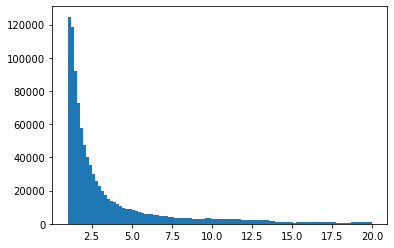

In [4]:
# New probability distribution
def p(y):
    if (y>=1) and (y<=20):
        return y**(-2)
    else:
        return 0


# Settings
N = 10**6       # Number of randomly generated points.
y_init = 2      # Initial starting point
sigma = 0.1     # Effective step size for proposal probability.

# Preallocation and initialization
y = np.zeros(N) 
y[0] = y_init

# Metrolpolis-Hasting's algorithm:
for i in range(N-1):
    flag = True
    while flag:
        # When current state is y, propose new state y' with proposal probability q(x->x')
        y_current = y[i]
        y_next = np.random.normal(y_current, sigma)

        # Calculate the Hasting's ratio:
        if p(y_current) == 0:   # This condition is only to avoid division by zero.
            r = 1                   
        else:
            r = min([1, p(y_next)/p(y_current)])
        
        # Draw a new random number u 
        u = np.random.random()
     
        # Accept or reject the proposed new state with probability r.  
        if u <= r:
            # Accepting the state.
            y[i+1] = y_next
            flag = False

plt.hist(y, bins=100)
plt.savefig("metropolis.eps", format='eps', bbox_inches='tight')

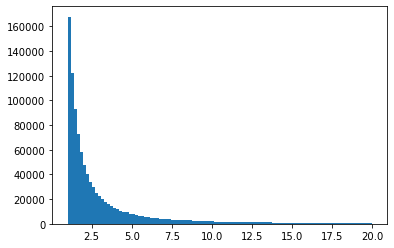

In [5]:
# Analytical probability transformation
def exact_inversion(x):
    return 1/(1-19/20*x)

x = np.random.random(N)
y2 = exact_inversion(x)
plt.hist(y2, bins=100)
plt.savefig("exact_inversion.eps", format='eps', bbox_inches='tight')